# Primary Forward Modeling Notebook
Goal here is to have some config in the first cell that then lets us generate the figures and data that we need for the remainder of the simulation. Let most of the code live in `gsmt.py`

In [1]:
# User config if I want to be fancy
gsmt = 'GMT'
band = 'I'
segment_variation = True
coro_order = 4

In [2]:
from hcipy import *
import matplotlib.pyplot as plt
import numpy as np
from poke.poke_core import Rayfront
import poke.plotting as plot
import zosapi
from gsmt import filters

In [3]:
# connect to the GMT and run a PRT
zos = zosapi.App() # init connection to make zmx happy
pth = 'C:/Users/UASAL-OPTICS/Desktop/polarization-gsmts-II/raytraces/GMT.zmx'

# telescope_params
D_tel = 25.448
F_tel = 207.589
wvl = filters['I'] * 1e-6 # get into meters
order = 2
npix = 1024

nrays = npix
wavelength = wvl
pupil_radius = D_tel / 2
max_fov = 1e-6
n_Al = 2.7671 + 1j*8.3172
n_Al2O3 = 1.6708 # 2.2527 + 1j*7.2810

grid = make_pupil_grid(npix,D_tel)

In [24]:
# Make the variable segment coating from a PSDWFE
# I grab this from phase bc we are really just interested in the physical deposition, which we scale anyways
def gen_psd_wfe(nominal_thickness=8e-9,nominal_ptv=0.02,exponent=-3):
    nominal_ptv *= nominal_thickness
    al2o3_layer = SurfaceAberration(grid,ptv=2*0.08e-9,diameter=np.sqrt(2)*D_tel,exponent=exponent).phase(wvl) 
    al2o3_layer /= np.max(al2o3_layer)
    al2o3_layer *= nominal_ptv
    al2o3_layer += nominal_thickness
    return al2o3_layer,nominal_thickness

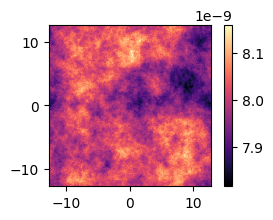

In [43]:
al2o3_layer,nominal_thickness = gen_psd_wfe(exponent=-3)
imshow_field(al2o3_layer)
plt.colorbar()

In [44]:
# set up coatings
# np.copy(al2o3_layer)
oxidized_Al = [
    (np.full_like(al2o3_layer,n_Al2O3,dtype=np.complex128),np.copy(al2o3_layer)),
    (np.full_like(al2o3_layer,n_Al,dtype=np.complex128)) # substrate
]

overcoat_Al = [
    (np.full_like(al2o3_layer,n_Al2O3,dtype=np.complex128),np.full_like(al2o3_layer,nominal_thickness)),
    (np.full_like(al2o3_layer,n_Al,dtype=np.complex128)) # substrate
]

m1 = {'surf':1,'coating':oxidized_Al,'mode':'reflect'}
m2 = {'surf':2,'coating':overcoat_Al,'mode':'reflect'}
m3 = {'surf':5,'coating':overcoat_Al,'mode':'reflect'}

In [36]:
rf = Rayfront(nrays,wavelength,pupil_radius,max_fov,circle=False)
rf.as_polarized([m1,m2,m3])
rf.trace_rayset(pth)
rf.wavelength = wvl

norm fov =  [0. 0.]
base ray shape  (4, 1048576)
tracing with global coordinates
tracing with global coordinates
tracing with global coordinates
1 Raysets traced through 3 surfaces


In [45]:
rf.surfaces = [m1,m2,m3]

In [46]:
# compute the jones pupil
rf.compute_jones_pupil(aloc=np.array([0.,1.,0.]))
# plot.jones_pupil(rf)

In [47]:
from poke.interfaces import jones_pupil_to_hcipy_wavefront

wvfnt = jones_pupil_to_hcipy_wavefront(rf.jones_pupil,grid,shape=npix)

In [48]:
if D_tel != 1:
    normalize_aperture = False
aperture = evaluate_supersampled(make_gmt_aperture(normalized=normalize_aperture,with_spiders=False),grid,1)
focal_grid = make_focal_grid(8,15,spatial_resolution=wvl/D_tel*F_tel)
prop = FraunhoferPropagator(grid,focal_grid,focal_length=F_tel)

# condition e field
wvfnt.electric_field *= aperture
wvfnt.total_power = 1.0
wvfnt.wavelength = wvl

# apply e field correction
avg_phase = (wvfnt.phase[0,0] + wvfnt.phase[1,1]) / 2
wvfnt.electric_field *= np.exp(-1j*avg_phase)


norm = prop(wvfnt).power.max()
coronagraph = PerfectCoronagraph(aperture, 6)
wfout = prop(coronagraph(wvfnt))


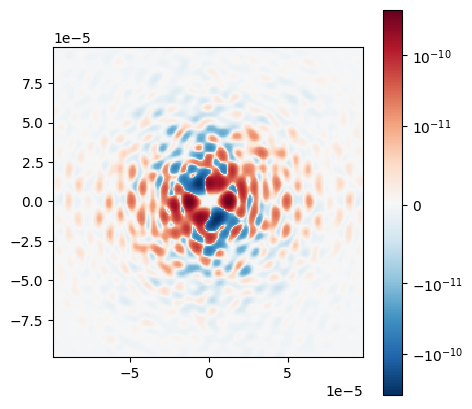

In [49]:
from matplotlib.colors import SymLogNorm
nominal = np.load('gmt_al2o3_order6_nospatialvariation.npy')
plt.figure(figsize=[5,5])
imshow_field(((wfout.power - nominal)/norm),cmap='RdBu_r',norm=SymLogNorm(1e-11))
plt.colorbar()

In [50]:
np.save('gmt_al2o3_order6_expm3.npy',wfout.power)

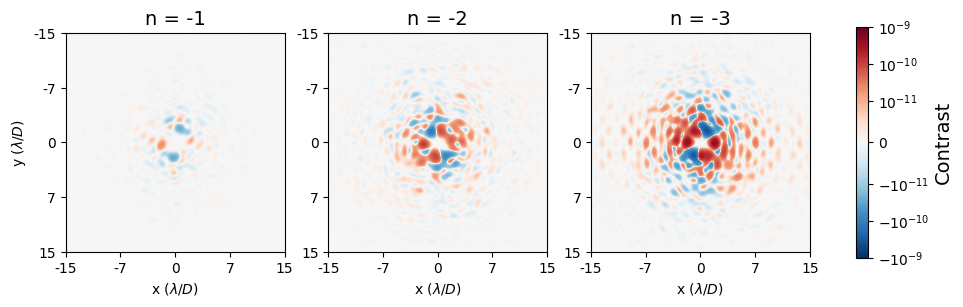

In [90]:
# Focal plane ticks
plt.style.use('default')
shape = wfout.power.shaped.shape[0]
ticks = np.linspace(0,shape,5)
ticklabels = np.linspace(-15,15,len(ticks))
ticklabels_str = [str(int(i)) for i in ticklabels]
i = 1
data = [np.load(f'gmt_al2o3_order6_expm{i}.npy').reshape([shape,shape]) for i in range(1,4)]
fig,axs = plt.subplots(figsize=[12,3],ncols=3)
for ax,dat in zip(axs,data):
    im = ax.imshow((dat-nominal.reshape([shape,shape]))/norm,cmap='RdBu_r',norm=SymLogNorm(1e-11,vmin=-1e-9,vmax=1e-9))
    ax.set_title(f'n = -{i}',fontsize=14)
    i += 1

    # config focal tix
    ax.set_xticks(ticks-0.5) # half pixel offset fixes tick placement
    ax.set_xticklabels(ticklabels_str)
    ax.set_yticks(ticks-0.5) # half pixel offset fixes tick placement
    ax.set_yticklabels(ticklabels_str)
    ax.set_xlabel('x '+r'($\lambda / D$)')
axs[0].set_ylabel('y '+r'($\lambda / D$)')
cb = fig.colorbar(im,ax=axs)
cb.set_label(label='Contrast',size=14)
plt.show()

In [57]:
len(data)

3